# Parameter Space

To run a DYNAMITE model, one must specify a number of parameteters for the gravitational potential. The aim of this notebook is to demonstrate how to specify these parameters are specified, and to highlight featues that we have implemented in order to help you explore parameter space. 

We'll start as before by reading the same configuration file as previously,

In [1]:
import dynamite as dyn

# read the config file
fname = 'NGC6278_config.yaml'
c = dyn.config_reader.Configuration(fname, silent=True)

No previous models have been found:
Making an empty table in AllModels.table


When the configuration object is created, internally, a parameter space object is created. This ``parspace`` object is a list, and every entry of this list is a parameter in our model,  Lets extract this and have a look

In [2]:
# extract the parameter space 
parspace = c.parspace
print('type of parspace is', type(parspace))
print('length of parspace is', len(parspace))
print('the parameter names are:')
for par in parspace:
    print('   -', par.name)

type of parspace is <class 'parameter_space.ParameterSpace'>
length of parspace is 8
the parameter names are:
   - mass
   - a
   - dc
   - f
   - q
   - p
   - u
   - ml


Several properties are specified for each parameter in the configuration file. Let's look at the value

In [3]:
print('Parameter / value :')
for par in c.parspace:
    print(f'   {par.name} = {par.value}')

Parameter / value :
   mass = 6.0
   a = 0.001
   dc = 10.0
   f = 1.0
   q = 0.54
   p = 0.99
   u = 0.9999
   ml = 4.0


These are the starting values from which we would like to run a model.

One complication in specifying these values is that, for some parameters, we would like to take logarithmically spaced steps through parameter space, i.e. the ones which are specificed as
```
parameters -> XXX -> logarithmic : True
```
Logarithmically spaced steps can be useful for exploring mass parameters. For other parameters (e.g. length scales) linearly spaced steps may be more appropriate. For other types of parameters (e.g. angles) a different spacing altogether may be preferable.

To handle these possibilities, we introduce the concept of ``raw`` parameter values, distinct from the values themselves. All values associated with parameter in the configuration file are given in ``raw`` units. When we step through parameter space, we take linear steps in ``raw`` values. The conversion from raw values to the parameter values is handles by the method
```
Parameter.get_par_value_from_raw_value
```
So to convert the above list from raw values, we can do the following,

In [4]:
print('Parameter / value :')
for par in c.parspace:
    raw_value = par.value
    par_value = par.get_par_value_from_raw_value(raw_value)
    print(f'   {par.name} = {par_value}')

Parameter / value :
   mass = 1000000.0
   a = 0.001
   dc = 10.0
   f = 10.0
   q = 0.54
   p = 0.99
   u = 0.9999
   ml = 4.0


Notice how only those parameters which have been specified with ``logarithmic : True`` have been modified.

Another property that we specifie for each parameter is whether or not it is fixed, including a value and whether or not the parameter is fixed,

In [5]:
for par in parspace:
    if par.fixed is True:
        fix_string = ' is fixed.'
    if par.fixed is False:
        fix_string = ' is NOT fixed.'
    print(f'{par.name}{fix_string}')

mass is fixed.
a is fixed.
dc is fixed.
f is NOT fixed.
q is fixed.
p is fixed.
u is fixed.
ml is NOT fixed.


The only parameters which are not fixed for this example are the dark matter fraction ``f`` and the mass-to-light ratio ``ml``. For these free parameters, additional properties about how search through parameter space are stored in the ``par_generator_settings`` attribute,

In [6]:
for par in parspace:
    if par.fixed is False:
        tmp = par.par_generator_settings
        lo, hi, step = tmp['lo'], tmp['hi'], tmp['step']
        print(f'{par.name} takes step-size {step} and bounds ({lo,hi})')

f takes step-size 0.5 and bounds ((0.0, 3.0))
ml takes step-size 1.0 and bounds ((0.5, 5.0))


How do we search over these free parameters? Running models (especially calcuating the orbit library) is expensive, so we will want to search through parameter space in the most efficient way possible.

In general, an algorithm to search through parameter space will take as input
1. the output of all models which have been run so far (e.g. chi-squared values)
2. setting for the free parameters (e.g. step-size and bounds)
The algorithm will then output a new list of parameters for which we want to run models.

In DYNAMITE, we implement this generic idea in the class
``dyn.parameter_sapce.ParameterGenerator``
In the configuration file, you specify *which* parameter generator you would like to use, at the location
```
parameter_space_settings -> generator_type
```
The current choice is 

In [7]:
c.settings.parameter_space_settings['generator_type']

'LegacyGridSearch'

This parameter generator requires an additional setting which is set at,
```
parameter_space_settings -> generator_settings -> threshold_del_chi2
```
which is accessed in the following way,

In [8]:
threshold_del_chi2 = c.settings.parameter_space_settings['generator_settings']['threshold_del_chi2']
print(f'threshold_del_chi2 = {threshold_del_chi2}')

threshold_del_chi2 = 0.5


The algorithm implemented to generate parameters in ``LegacyGridSearch`` is the following,

```
iteration = 0
if iteration == 0
    all parameters take `value` specified in the config
else:
    1. find the model with the lowest chi-squared
    2. find all models with chi-squared within threshold_del_chi2 of the lowest value
    3. for all models satisfying that criteria:
        - for all free parameters:
            - generate a new parameter set +/-1 step-size from the current value
    4. Remove any models with parameters outside specified bounds
    5. iteration = iteration + 1
    6. halve all parameter stepsizes, unless this causes them to go below their specified minstepsize
stop if no new models are added, or any other stopping criteria are met    
```

For those of you who have used the previous version of the trixial Schwarzschild modelling code (aka ``schwpy``), this is the same algorithm which was implemented there.

The last line of the algorithm mentions stopping criteria. Settings which control the stopping criteria are also speicified in the configuration file, under
```
parameter_space_settings -> stopping_criteria
```
The current settings are the following,

In [9]:
stopping_criteria = c.settings.parameter_space_settings['stopping_criteria']
for key in stopping_criteria:
    print(f'{key} = {stopping_criteria[key]}')

min_delta_chi2 = 0.5
n_max_mods = 50
n_max_iter = 10


These settings are used to implement the following stopping criteria:

- if no new model in the last iteration impoves the chi-squared by at least ``min_delta_chi2``, then stop
- if we have already run ``n_max_mods`` models, then stop
- if we have already run ``n_max_iter`` iterations, then stop

Let's see parameter generation in action!

Since running a real Schwarzschild model is slightly time-consuming, in order to see parameter generation in action, we can run a dummy model instead. To run a dummy model, we must define a dummy chi-squared. For a simple option, we can specify some ''true'' values, with the dummy chi-squared being the squared distance from these true values

In [10]:
import numpy as np

f_true = 1.7
ml_true = 1.8
def dummy_chi2_function(parset):
    delta_log10_f = np.log10(parset['f']/f_true)
    delta_ml = parset['ml'] - ml_true
    dummy_chi2 = delta_log10_f**2. + delta_ml**2.
    return dummy_chi2

Next, create a model iterator object

In [11]:
mod_iterator = dyn.model_iterator.ModelIterator(
    system=c.system,
    all_models=c.all_models,
    settings=c.settings,
    executor=c.executor,
    do_dummy_run=True,
    dummy_chi2_function=dummy_chi2_function)

LegacyGridSearch: "iteration 0"
LegacyGridSearch added 1 new model(s) out of 1
... running model 1 out of 1
LegacyGridSearch: "iteration 1"
LegacyGridSearch added 4 new model(s) out of 4
... running model 1 out of 4
... running model 2 out of 4
... running model 3 out of 4
... running model 4 out of 4
LegacyGridSearch: "iteration 2"
LegacyGridSearch added 3 new model(s) out of 3
... running model 1 out of 3
... running model 2 out of 3
... running model 3 out of 3
LegacyGridSearch: "iteration 3"
LegacyGridSearch added 3 new model(s) out of 3
... running model 1 out of 3
... running model 2 out of 3
... running model 3 out of 3
LegacyGridSearch: "iteration 4"
LegacyGridSearch added 2 new model(s) out of 2
... running model 1 out of 2
... running model 2 out of 2
LegacyGridSearch: "iteration 5"
LegacyGridSearch added 2 new model(s) out of 2
... running model 1 out of 2
... running model 2 out of 2
LegacyGridSearch: "iteration 6"
LegacyGridSearch added 6 new model(s) out of 7
... running 

Let's make plots of the evaluated chi-squared values



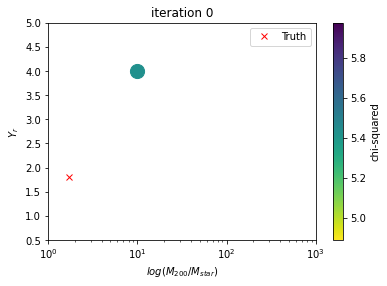

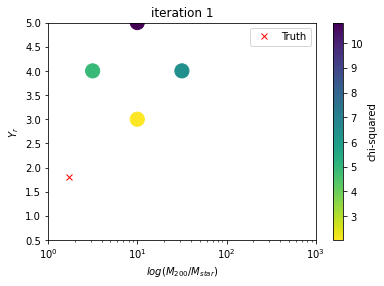

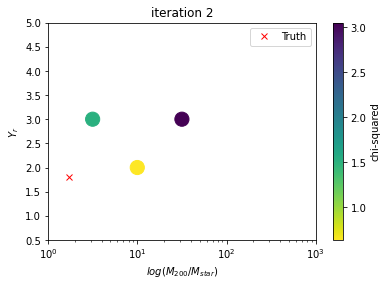

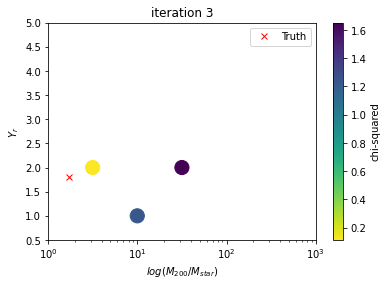

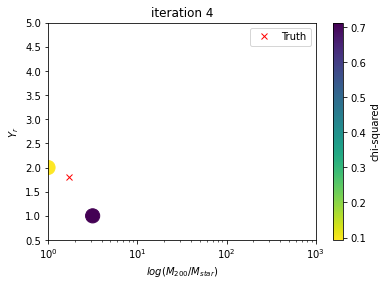

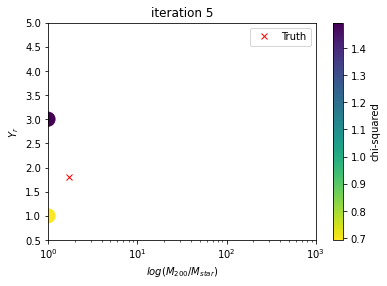

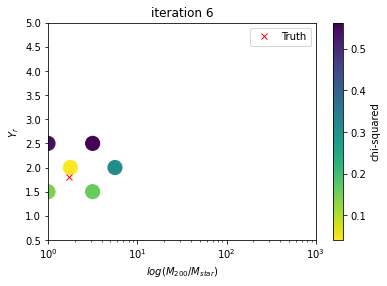

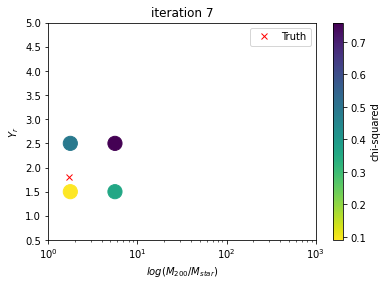

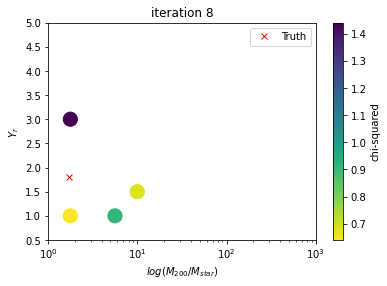

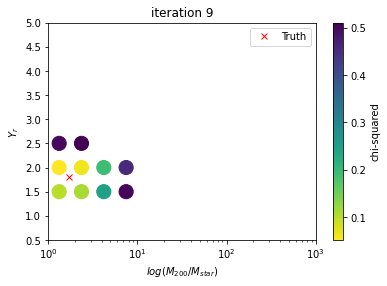

In [12]:
import matplotlib.pyplot as plt

# get a list of all the iterations which have been run
iterations = np.unique(c.all_models.table['which_iter'])

# get parameter limits specified in the config file
f = c.parspace.get_parameter_from_name('f')
f_lims = (10.**f.par_generator_settings['lo'], 10.**f.par_generator_settings['hi'])
ml = c.parspace.get_parameter_from_name('ml')
ml_lims = (ml.par_generator_settings['lo'], ml.par_generator_settings['hi'])

# plot the models: f vs ml at each iteration:
for iter0 in iterations:
    table = c.all_models.table
    table = table[table['which_iter']==iter0]
    plt.scatter(table['f'],
                table['ml'],
                c=table['chi2'],
                cmap=plt.cm.viridis_r,
                s=200)
    plt.plot(f_true, ml_true, 'xr', label='Truth')
    plt.gca().legend()
    cbar = plt.colorbar()
    cbar.set_label('chi-squared')
    plt.gca().set_title(f'iteration {iter0}')
    plt.gca().set_xlim(*f_lims)
    plt.gca().set_ylim(*ml_lims)
    plt.gca().set_xlabel(f.LaTeX)
    plt.gca().set_ylabel(ml.LaTeX)
    plt.gca().set_xscale('log')
    plt.show()

We see the parameters that we generate at each step closing in on the true values. Later iterations take smaller step-sizes compared to earlier iterations.

**Exercise** : change the parameter generator type specified in the configuration file from ``LegacyGridSearch`` to ``GridWalk`` and re-run this notebook. How do the results change?

``GridWalk`` is a simpler parameter generation algorithm than the one we just seen. Rather than searching through all models within some tolerable chi-squared threshold, it simply walks directly in the direction in which the chi-squared value is decreasing. Step-sizes are not varied throughout any iterations.

Both ``LegacyGridSearch`` and ``GridWalk`` suffer from two crucial drawbacks:

- they are liable to fall into local minima
- they scale badly with the number of free parameters

We want to implement more efficient algorithms. One specific idea we have it to use Gaussian Process Emulators here. See [this paper](https://ui.adsabs.harvard.edu/abs/2019MNRAS.485.4878G/abstract) for an example.